# Load Data

In [1]:
! pip install pytorch_pretrained_bert
! pip install torchmetrics
! pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 19.3 MB/s 
     |████████████████████████████████| 132 kB 29.6 MB/s 
     |████████████████████████████████| 10.2 MB 49.7 MB/s 
     |████████████████████████████████| 79 kB 2.3 MB/s 
     |████████████████████████████████| 140 kB 29.9 MB/s 
     |████████████████████████████████| 127 kB 41.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 1.2 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/Capstone')
from utils import read_conll_file, read_data, filter_tag, create_sub_dir
from utils import (TAG2IDX, IDX2TAG, DATA_DIR, WSJ_DIR, MODEL_DIR, 
                   INT_RESULT_DIR, METRICS_DIR, RESULT_DIR, PLOT_TAGS_DIR)
from utils import wsj_train_word_lst, wsj_train_tag_lst, wsj_test_word_lst, wsj_test_tag_lst

from build_model import PosDataset, Net, DEVICE, TOKENIZER
from build_model import pad, train, eval

from analysis import save_sns_fig, save_plotly_fig, analysis_output

from create_pseudo_data import gen_pseudo_data

import os
from collections import Counter
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.utils import data
import torch.optim as optim
from pytorch_pretrained_bert import BertTokenizer, BertModel
from torchmetrics.functional.classification import multiclass_f1_score, multiclass_precision, multiclass_recall, multiclass_accuracy

torch.manual_seed(0)


Mounted at /content/drive
The number of samples: 30060
The number of tags 48
The number of samples: 1336
The number of tags 45
The number of samples: 1640
The number of tags 45


100%|██████████| 213450/213450 [00:00<00:00, 317191.92B/s]


In [3]:
model = Net(vocab_size=len(TAG2IDX))
model.to(DEVICE)
model = nn.DataParallel(model)

100%|██████████| 404400730/404400730 [00:33<00:00, 12105518.48B/s]


In [4]:
train_dataset = PosDataset(wsj_train_word_lst, wsj_train_tag_lst)
eval_dataset = PosDataset(wsj_test_word_lst, wsj_test_tag_lst)

train_iter = data.DataLoader(dataset=train_dataset,
                             batch_size=8,
                             shuffle=True,
                             num_workers=1,
                             collate_fn=pad)
test_iter = data.DataLoader(dataset=eval_dataset,
                             batch_size=8,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

optimizer = optim.Adam(model.parameters(), lr = 0.0001)

criterion = nn.CrossEntropyLoss(ignore_index=0)

In [5]:
model_file = os.path.join(MODEL_DIR, "base_model.pt")
model.load_state_dict(torch.load(model_file))
(wsj_precision_value, wsj_recall_value, wsj_f1_value, wsj_acc_value, 
 micro_wsj_precision_value, micro_wsj_recall_value, micro_wsj_f1_value, micro_wsj_acc_value,
 macro_wsj_precision_value, macro_wsj_recall_value, macro_wsj_f1_value, macro_wsj_acc_value) = eval(model, test_iter, save_output=False)

print(wsj_precision_value, wsj_recall_value, wsj_f1_value, wsj_acc_value)
print(micro_wsj_precision_value, micro_wsj_recall_value, micro_wsj_f1_value, micro_wsj_acc_value)
print(macro_wsj_precision_value, macro_wsj_recall_value, macro_wsj_f1_value, macro_wsj_acc_value)


tensor(0.9771) tensor(0.9743) tensor(0.9751) tensor(0.9743)
tensor(0.9743) tensor(0.9743) tensor(0.9743) tensor(0.9743)
tensor(0.8648) tensor(0.8656) tensor(0.8558) tensor(0.8656)


# Self Training

In [6]:
file_name_lst = ["answers", "emails", "newsgroups", "reviews", "weblogs"]

In [7]:
domain = "weblogs"
domain_dir = os.path.join(DATA_DIR, "pos_fine", f"{domain}")
domain_dev_file = os.path.join(domain_dir, f"gweb-{domain}-dev.conll")
domain_test_file = os.path.join(domain_dir, f"gweb-{domain}-test.conll")

In [8]:
domain_dev_word_lst, domain_dev_tag_lst, domain_dev_tag_set = read_data(domain_dev_file)
domain_test_word_lst, domain_test_tag_lst, domain_test_tag_set = read_data(domain_test_file)
domain_dev_word_lst, domain_dev_tag_lst = filter_tag(domain_dev_word_lst, domain_dev_tag_lst)  
domain_test_word_lst, domain_test_tag_lst = filter_tag(domain_test_word_lst, domain_test_tag_lst)

The number of samples: 1016
The number of tags 47
The number of samples: 1015
The number of tags 49
after filter tag 1016
after filter tag 974


In [9]:
# method_name: Online_fixed_self_learning, Online_nonfixed_self_learning, 
#               Scratch_fixed_self_learning, Scratch_nonfixed_self_learning,
#               Online_token_self_learning, Scratch_token_self_learning

(sub_model_dir, sub_metrics_dir, sub_result_dir, 
 sub_plots_tags_dir, sub_int_res_dir) = create_sub_dir(domain, method_name="Online_fixed_self_learning")

In [10]:
domain_precision_value_lst = []
domain_recall_value_lst = []
domain_f1_value_lst = []
domain_acc_value_lst = []

micro_domain_precision_value_lst = []
micro_domain_recall_value_lst = []
micro_domain_f1_value_lst = []
micro_domain_acc_value_lst = []

macro_domain_precision_value_lst = []
macro_domain_recall_value_lst = []
macro_domain_f1_value_lst = []
macro_domain_acc_value_lst = []

In [11]:
loop_i = 0
top_percent = 0.1

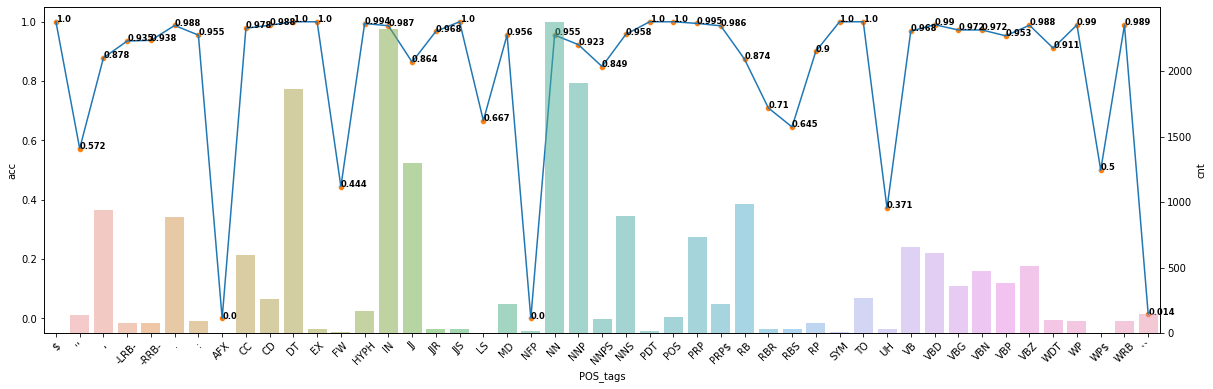

In [12]:
domain_test_dataset = PosDataset(domain_test_word_lst, domain_test_tag_lst)

domain_test_iter = data.DataLoader(dataset=domain_test_dataset,
                             batch_size=8,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

output_res_file = os.path.join(sub_result_dir, f"top{top_percent}-loop{loop_i}.txt")
(domain_precision_value, domain_recall_value, domain_f1_value, domain_acc_value,
 precision_value_micro, recall_value_micro, f1_value_micro, acc_micro, 
 precision_value_macro, recall_value_macro, f1_value_macro, acc_macro) = eval(model, domain_test_iter, save_output=True, output_file=output_res_file)

csv_file_name = os.path.join(sub_plots_tags_dir, f"top{top_percent}-loop{loop_i}.csv")
output_plot_name = os.path.join(sub_plots_tags_dir, f"top{top_percent}-loop{loop_i}.png")
_ = analysis_output(output_res_file, csvsave=True, pngsave=True, csv_file_name=csv_file_name, output_plot_name=output_plot_name)

domain_precision_value_lst.append(domain_precision_value)
domain_recall_value_lst.append(domain_recall_value)
domain_f1_value_lst.append(domain_f1_value)
domain_acc_value_lst.append(domain_acc_value)

micro_domain_precision_value_lst.append(precision_value_micro)
micro_domain_recall_value_lst.append(recall_value_micro)
micro_domain_f1_value_lst.append(f1_value_micro)
micro_domain_acc_value_lst.append(acc_micro)

macro_domain_precision_value_lst.append(precision_value_macro)
macro_domain_recall_value_lst.append(recall_value_macro)
macro_domain_f1_value_lst.append(f1_value_macro)
macro_domain_acc_value_lst.append(acc_macro)


The number of sentences in top n 101

Loop 1
domain_dev_word_lst 1016


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


step: 0, loss: 0.00407974049448967
step: 10, loss: 0.002276249462738633

Loop 2
domain_dev_word_lst 915


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


step: 0, loss: 0.00438223872333765
step: 10, loss: 0.002185555873438716

Loop 3
domain_dev_word_lst 814


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


step: 0, loss: 0.005277690012007952
step: 10, loss: 0.002446272410452366

Loop 4
domain_dev_word_lst 713


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


step: 0, loss: 0.06256649643182755
step: 10, loss: 0.005550605710595846

Loop 5
domain_dev_word_lst 612


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


step: 0, loss: 0.00942965317517519
step: 10, loss: 0.023385915905237198

Loop 6
domain_dev_word_lst 511


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


step: 0, loss: 0.018839063122868538
step: 10, loss: 0.06356438994407654

Loop 7
domain_dev_word_lst 410


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


step: 0, loss: 0.023331427946686745
step: 10, loss: 0.07154190540313721

Loop 8
domain_dev_word_lst 309


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


step: 0, loss: 0.04487907513976097
step: 10, loss: 0.06589944660663605

Loop 9
domain_dev_word_lst 208


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


step: 0, loss: 0.04831024259328842
step: 10, loss: 0.031387753784656525

Loop 10
domain_dev_word_lst 107


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


step: 0, loss: 0.06868669390678406
step: 10, loss: 0.07158324867486954


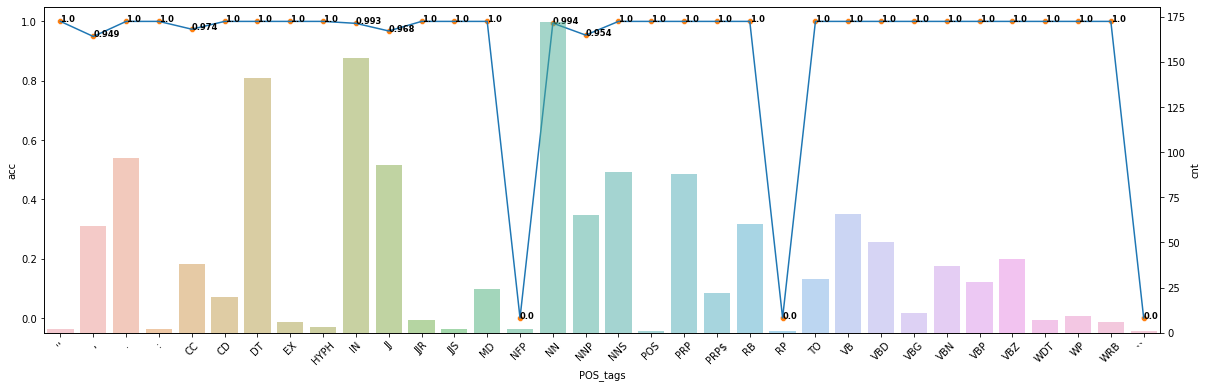

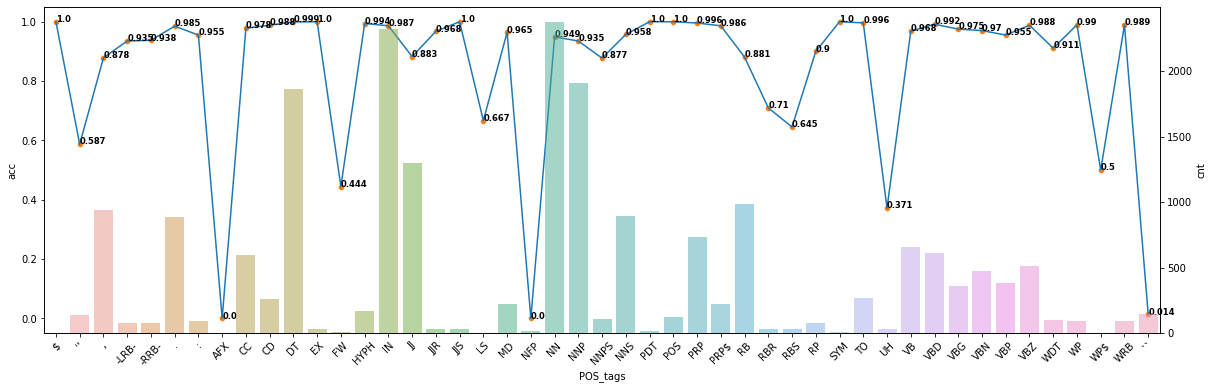

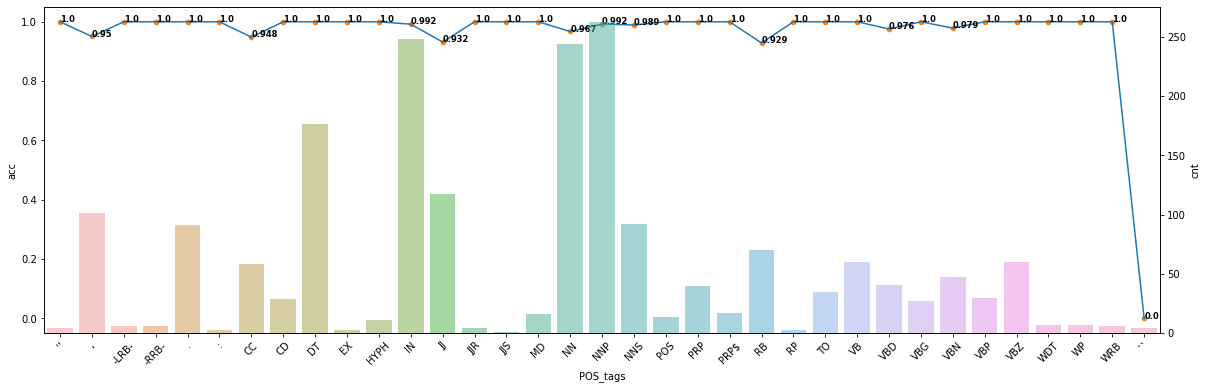

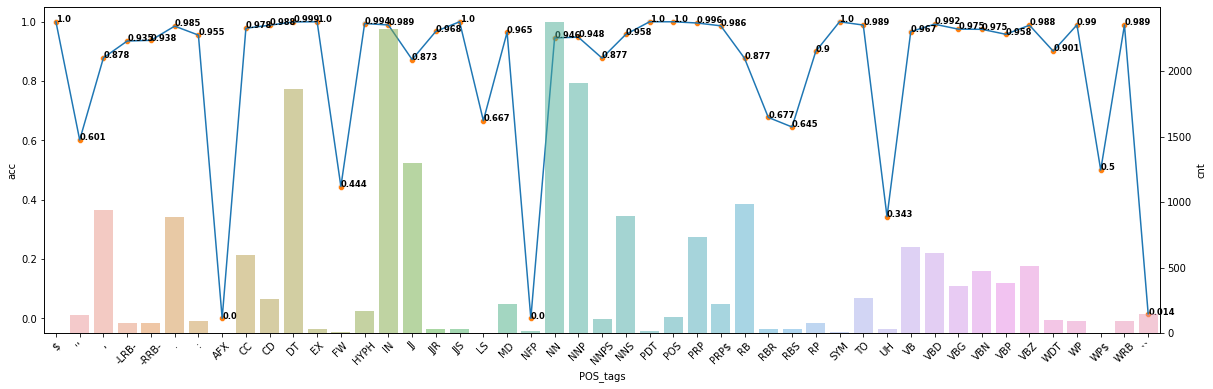

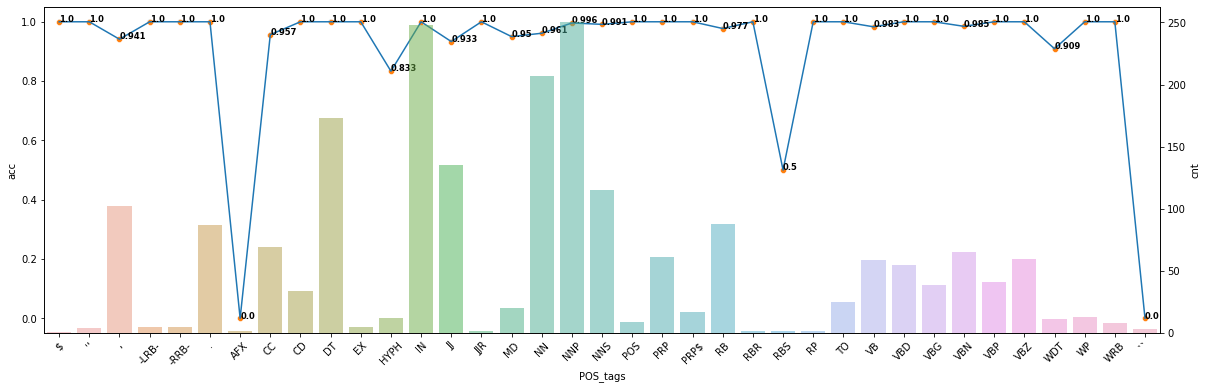

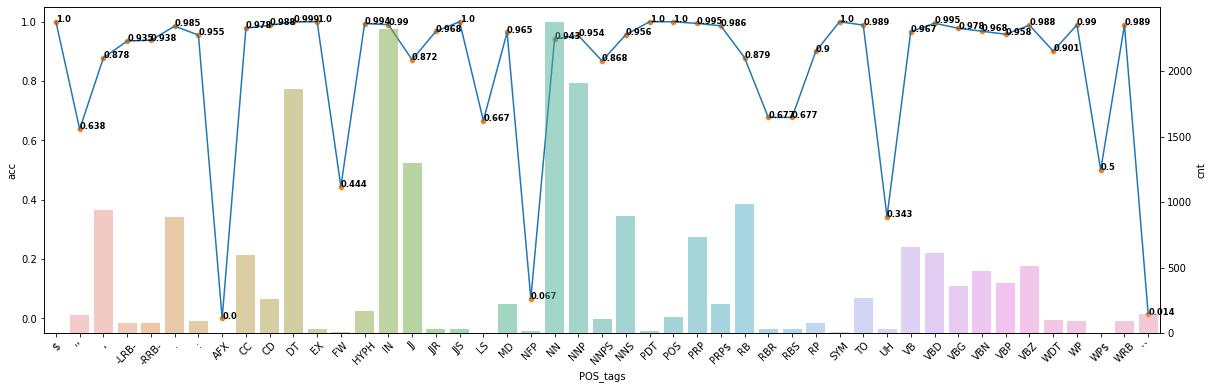

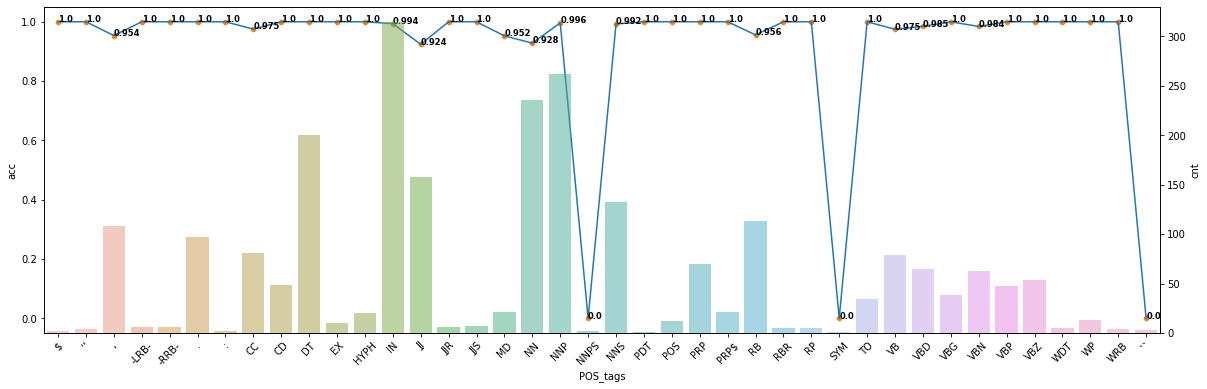

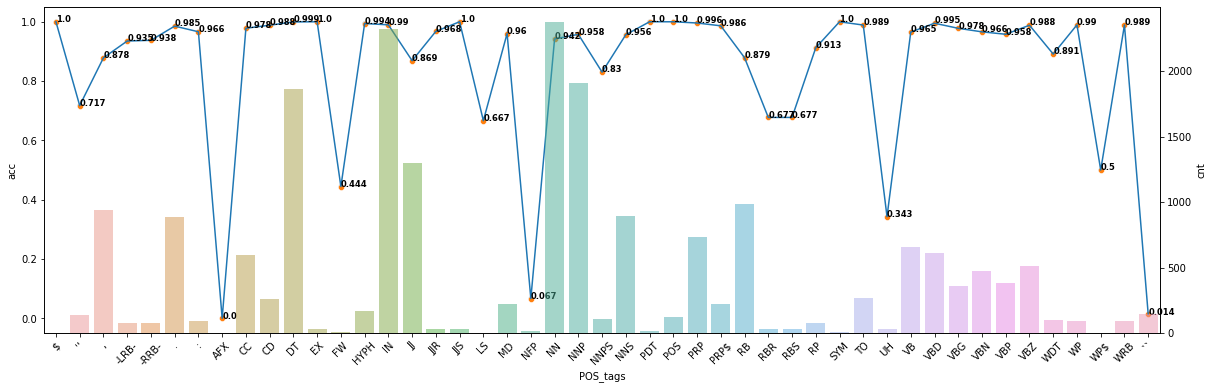

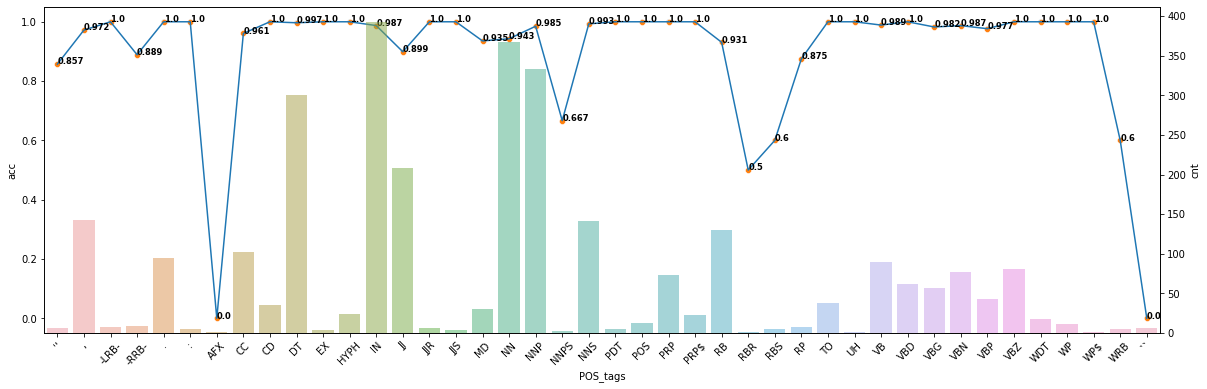

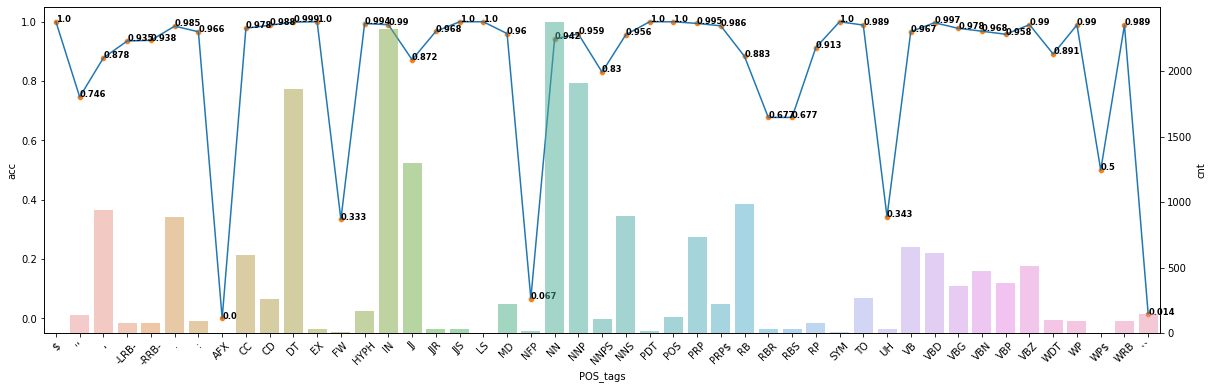

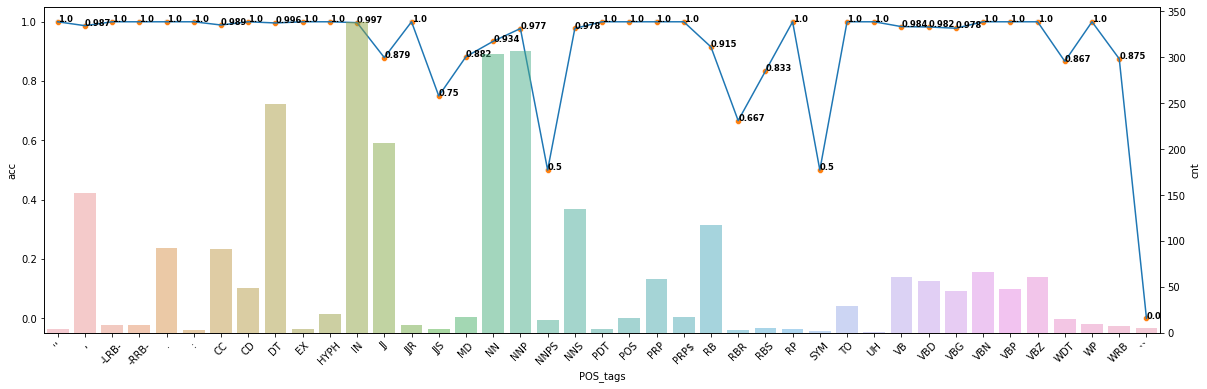

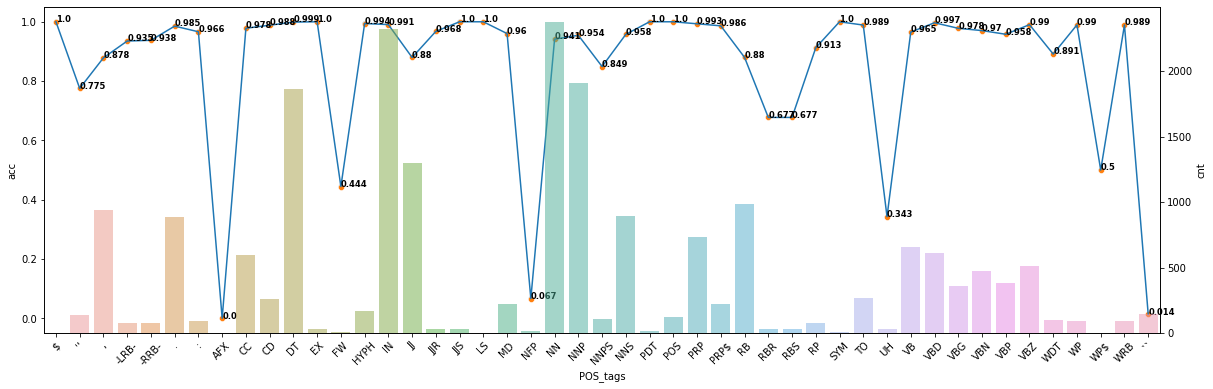

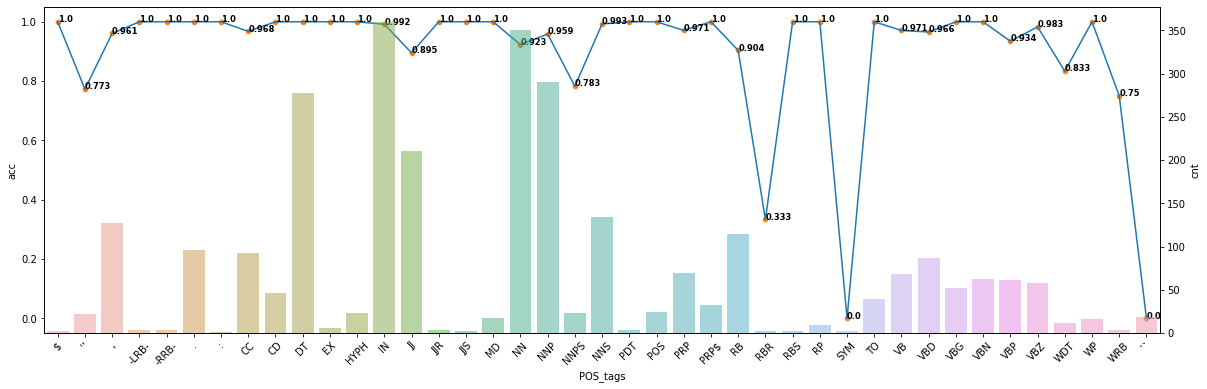

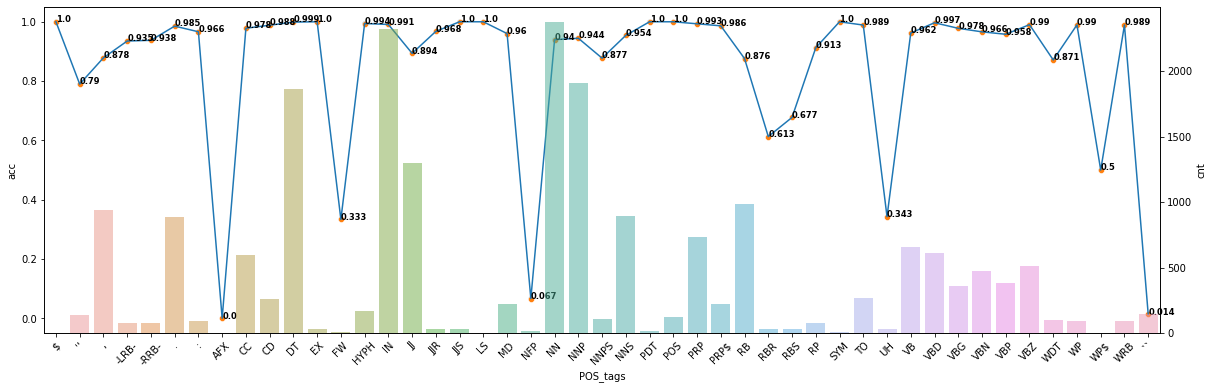

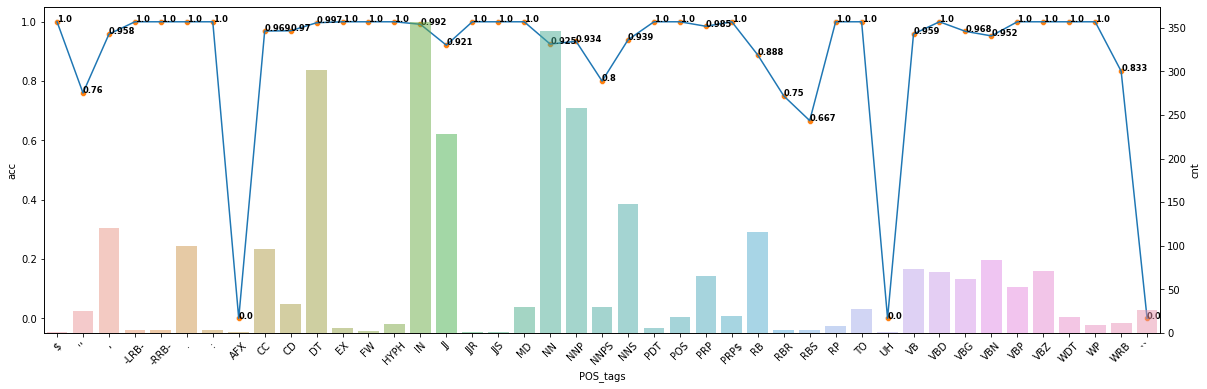

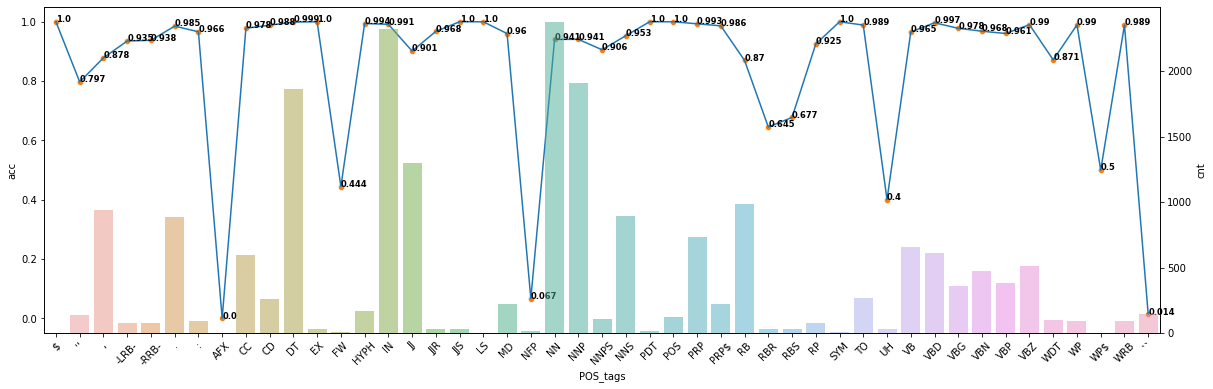

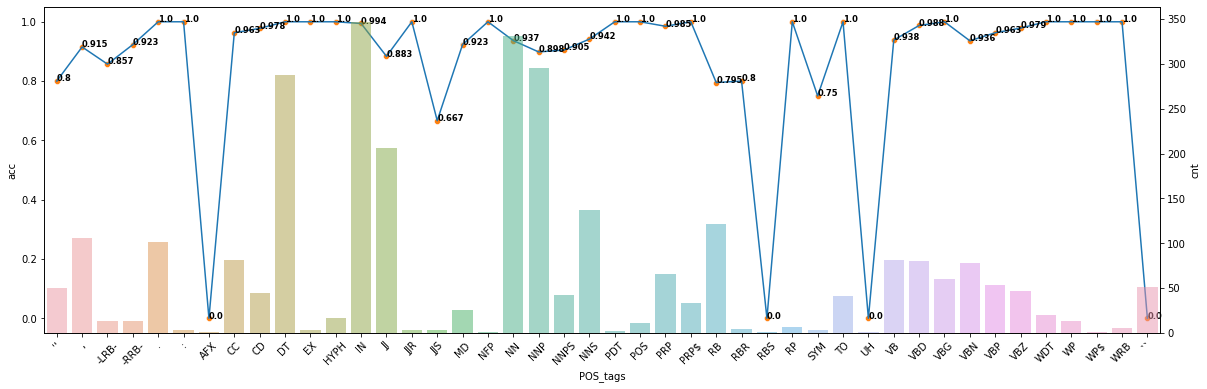

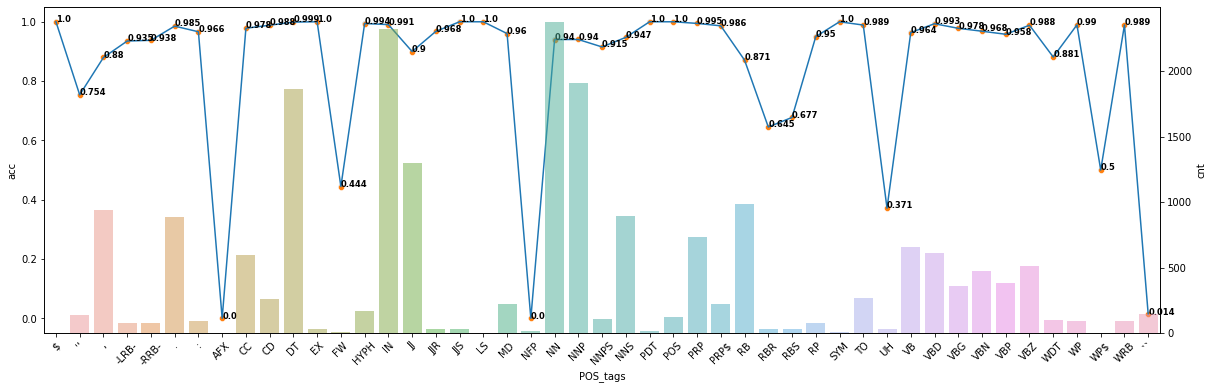

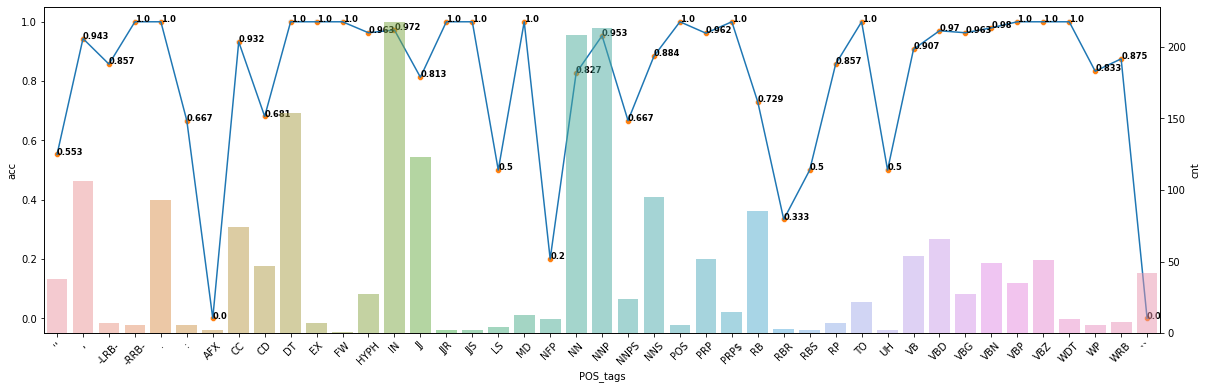

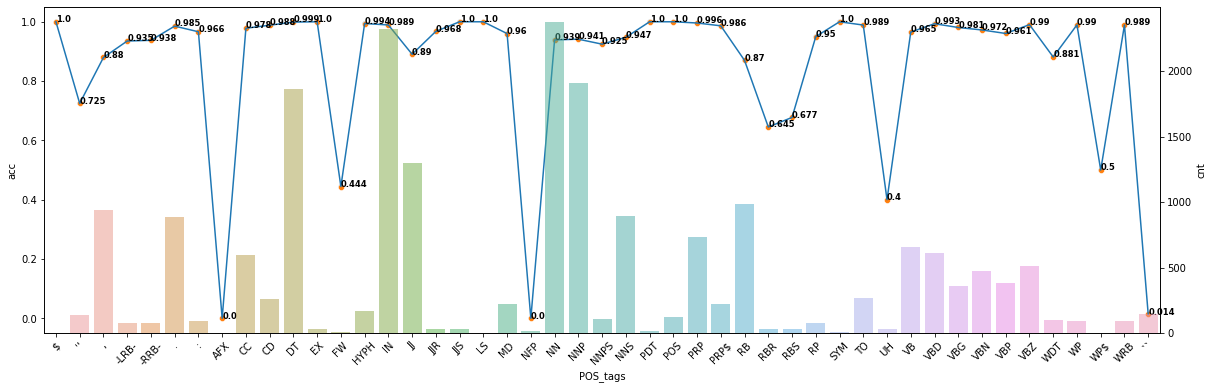

In [13]:
acc_lst = []
prob_lst = []

topn = int(top_percent * len(domain_dev_word_lst))
print("The number of sentences in top n", topn)

while len(domain_dev_word_lst) >= topn:
  loop_i += 1
  print("\nLoop", loop_i)
  print("domain_dev_word_lst", len(domain_dev_word_lst))

  domain_dev_dataset = PosDataset(domain_dev_word_lst, domain_dev_tag_lst)

  domain_dev_iter = data.DataLoader(dataset=domain_dev_dataset,
                              batch_size=8,
                              shuffle=False,
                              num_workers=1,
                              collate_fn=pad)
  
  # Save analysis outputs for intermediate results
  int_csv_file_name = os.path.join(sub_int_res_dir, f"top{top_percent}-loop{loop_i}.csv")
  int_output_plot_name = os.path.join(sub_int_res_dir, f"top{top_percent}-loop{loop_i}.png")
  output_int_res_file = os.path.join(sub_int_res_dir, f"top{top_percent}-loop{loop_i}.txt")

  (top_words, top_tags, top_pseudo_tags, top_prob, top_acc, remain_words, 
   remain_tags, remain_pseudo_tags, remain_prob, remain_acc)= gen_pseudo_data(
       model, domain_dev_iter, topn, save_output=True, output_file=output_int_res_file, 
       csvsave=True, pngsave=True, csv_file_name=int_csv_file_name, output_plot_name=int_output_plot_name)

  new_train_dataset = PosDataset(top_words, top_pseudo_tags)
  new_train_iter = data.DataLoader(dataset=new_train_dataset,
                              batch_size=8,
                              shuffle=True,
                              num_workers=1,
                              collate_fn=pad)
  
  domain_dev_word_lst = remain_words
  domain_dev_tag_lst = remain_tags

  optimizer = optim.Adam(model.parameters(), lr = 0.00001)
  criterion = nn.CrossEntropyLoss(ignore_index=0)

  train(model, new_train_iter, optimizer, criterion)

  # # Save models
  # model_file = os.path.join(sub_model_dir, f"top{top_percent}-loop{loop_i}.pt")
  # torch.save(model.state_dict(), model_file)

  # Save final results
  output_res_file = os.path.join(sub_result_dir, f"top{top_percent}-loop{loop_i}.txt")
  (domain_precision_value, domain_recall_value, domain_f1_value, domain_acc_value,
   precision_value_micro, recall_value_micro, f1_value_micro, acc_micro, 
   precision_value_macro, recall_value_macro, f1_value_macro, acc_macro) = eval(model, domain_test_iter, save_output=True, output_file=output_res_file)

  domain_precision_value_lst.append(domain_precision_value)
  domain_recall_value_lst.append(domain_recall_value)
  domain_f1_value_lst.append(domain_f1_value)
  domain_acc_value_lst.append(domain_acc_value)

  micro_domain_precision_value_lst.append(precision_value_micro)
  micro_domain_recall_value_lst.append(recall_value_micro)
  micro_domain_f1_value_lst.append(f1_value_micro)
  micro_domain_acc_value_lst.append(acc_micro)

  macro_domain_precision_value_lst.append(precision_value_macro)
  macro_domain_recall_value_lst.append(recall_value_macro)
  macro_domain_f1_value_lst.append(f1_value_macro)
  macro_domain_acc_value_lst.append(acc_macro)

  acc_lst.append(top_acc)
  prob_lst.append(top_prob)

  # Save analysis outputs for final results
  csv_file_name = os.path.join(sub_plots_tags_dir, f"top{top_percent}-loop{loop_i}.csv")
  output_plot_name = os.path.join(sub_plots_tags_dir, f"top{top_percent}-loop{loop_i}.png")
  _ = analysis_output(output_res_file, csvsave=True, pngsave=True, csv_file_name=csv_file_name, output_plot_name=output_plot_name)


In [14]:
# acc_df = pd.DataFrame()
# for i in range(len(acc_lst)):
#   acc_df[f"Loop{i}"] = acc_lst[i]

# prob_df = pd.DataFrame()
# for i in range(len(prob_lst)):
#   prob_df[f"Loop{i}"] = prob_lst[i]

In [15]:
# print(domain_precision_value_lst)
# print(domain_recall_value_lst)
# print(domain_f1_value_lst)
# print(domain_acc_value_lst)

# print(acc_lst)
# print(prob_lst)

In [16]:
def plot_metric(precision, recall, f1, acc):

  test_metric = pd.DataFrame({
      "Loop": list(range(len(precision))) * 4,
      "metric": ["precision"]*len(precision) + ["recall"]*len(recall) + ["f1"]*len(f1) + ["accuracy"]*len(acc),
      "value": precision + recall + f1 + acc
  })

  fig = px.line(test_metric, x="Loop", y="value", color='metric', markers=True)
  fig.show()
  return test_metric

In [17]:
_ = plot_metric(domain_precision_value_lst, domain_recall_value_lst, domain_f1_value_lst, domain_acc_value_lst)

In [18]:
_ = plot_metric(micro_domain_precision_value_lst, micro_domain_recall_value_lst, micro_domain_f1_value_lst, micro_domain_acc_value_lst)

In [19]:
_ = plot_metric(macro_domain_precision_value_lst, macro_domain_recall_value_lst, macro_domain_f1_value_lst, macro_domain_acc_value_lst)

In [21]:
# prob_lst[0]